In [2]:
from google.colab import drive
import os
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATASET_PATH = '/content/drive/MyDrive/tumor_mri'
os.listdir(DATASET_PATH)

['pituitary', 'meningioma', 'glioma', 'healthy']

In [ ]:
#each folder is different class
pituitary_dir = "/content/drive/MyDrive/tumor_mri/pituitary"
meningioma_dir = "/content/drive/MyDrive/tumor_mri/meningioma"
healthy_dir = "/content/drive/MyDrive/tumor_mri/healthy"
glioma_dir = "/content/drive/MyDrive/tumor_mri/glioma"

print ('Total Pituitary images: ', len(os.listdir(pituitary_dir)))
print ('Total Meninginomia images: ', len(os.listdir(meningioma_dir)))
print ('Total Healthy images: ', len(os.listdir(healthy_dir)))
print ('Total Glioma images: ', len(os.listdir(glioma_dir)))
print('Total images: ', len(os.listdir(pituitary_dir))+len(os.listdir(meningioma_dir))+len(os.listdir(healthy_dir))+len(os.listdir(glioma_dir)))

Total Pituitary images:  1757
Total Meninginomia images:  1645
Total Healthy images:  2000
Total Glioma images:  1621
Total images:  7023


**Categorize into test and train set**

In [ ]:
import os
import shutil
import random

#  the source directory
source_dir = "/content/drive/MyDrive/tumor_mri"

# new destination directories for train and test
destination_dir = "/content/drive/MyDrive/tumor_mri_split"
train_dir = os.path.join(destination_dir, "train")
test_dir = os.path.join(destination_dir, "test")

# Create the destination train and test directories if they don't exist
if not os.path.exists(train_dir):
    os.makedirs(train_dir)

if not os.path.exists(test_dir):
    os.makedirs(test_dir)

# Loop through each class folder (pituitary, meningioma, healthy, glioma) in the source directory
for class_name in os.listdir(source_dir):
    class_path = os.path.join(source_dir, class_name)

    # Only process directories (i.e., class folders)
    if os.path.isdir(class_path):

        # Create the same class folder inside both train and test directories
        train_class_path = os.path.join(train_dir, class_name)
        test_class_path = os.path.join(test_dir, class_name)

        if not os.path.exists(train_class_path):
            os.makedirs(train_class_path)
        if not os.path.exists(test_class_path):
            os.makedirs(test_class_path)

        # Get all images in the class folder
        images = os.listdir(class_path)

        # Shuffle the images to randomize the selection
        random.shuffle(images)

        # Define the size of the test set (e.g., 20% for the test set)
        test_size = int(0.2 * len(images))

        # Move the images to the appropriate directories
        for image in images[:test_size]:
            # Move the image to the test folder
            shutil.move(os.path.join(class_path, image), os.path.join(test_class_path, image))

        for image in images[test_size:]:
            # Move the remaining images to the train folder
            shutil.move(os.path.join(class_path, image), os.path.join(train_class_path, image))

        print(f"Moved {test_size} images from {class_name} to the test directory.")
        print(f"Moved {len(images) - test_size} images from {class_name} to the train directory.")

print("Train and Test data split complete.")


Moved 351 images from pituitary to the test directory.
Moved 1406 images from pituitary to the train directory.
Moved 329 images from meningioma to the test directory.
Moved 1316 images from meningioma to the train directory.
Moved 324 images from glioma to the test directory.
Moved 1297 images from glioma to the train directory.
Moved 400 images from healthy to the test directory.
Moved 1600 images from healthy to the train directory.
Train and Test data split complete.


**Start from here**

In [3]:
import os

def count_images_in_directory(directory):
    """
    Count and display the number of images in each subdirectory.
    """
    print(f"Summary for directory: {directory}")
    total_images = 0
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            num_images = len(os.listdir(class_path))
            total_images += num_images
            print(f"Class: {class_name} - Number of images: {num_images}")
    print(f"Total images in {directory}: {total_images}\n")

# Define the new train and test directories
train_dir = "/content/drive/MyDrive/tumor_mri_split/train"
test_dir = "/content/drive/MyDrive/tumor_mri_split/test"

# Count images in the train directory
count_images_in_directory(train_dir)

# Count images in the test directory
count_images_in_directory(test_dir)


Summary for directory: /content/drive/MyDrive/tumor_mri_split/train
Class: pituitary - Number of images: 1406
Class: meningioma - Number of images: 1316
Class: glioma - Number of images: 1297
Class: healthy - Number of images: 1600
Total images in /content/drive/MyDrive/tumor_mri_split/train: 5619

Summary for directory: /content/drive/MyDrive/tumor_mri_split/test
Class: pituitary - Number of images: 351
Class: meningioma - Number of images: 329
Class: glioma - Number of images: 324
Class: healthy - Number of images: 400
Total images in /content/drive/MyDrive/tumor_mri_split/test: 1404



**Preprocess**

In [4]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt


In [5]:
#define the image size and batch size constant
IMAGE_SIZE =(224,224)
BATCH_SIZE = 32

In [6]:
# Define the ImageDataGenerator with validation split
train_datagen = ImageDataGenerator(
    rescale=1./255,         # Normalize pixel values to [0, 1]
    zoom_range=0.2,        # Random zoom
    validation_split=0.2
)

datagen = ImageDataGenerator(rescale=1./255)

#augment and normalize train dataset
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    seed=123,
    class_mode='categorical',
    subset='training'  # Use 80% for training
)

# normalize validation data
val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    seed=123,
    class_mode='categorical',
    subset='validation'  # Use 20% for validation
)

# normalize test data
test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


Found 4496 images belonging to 4 classes.
Found 1123 images belonging to 4 classes.
Found 1404 images belonging to 4 classes.


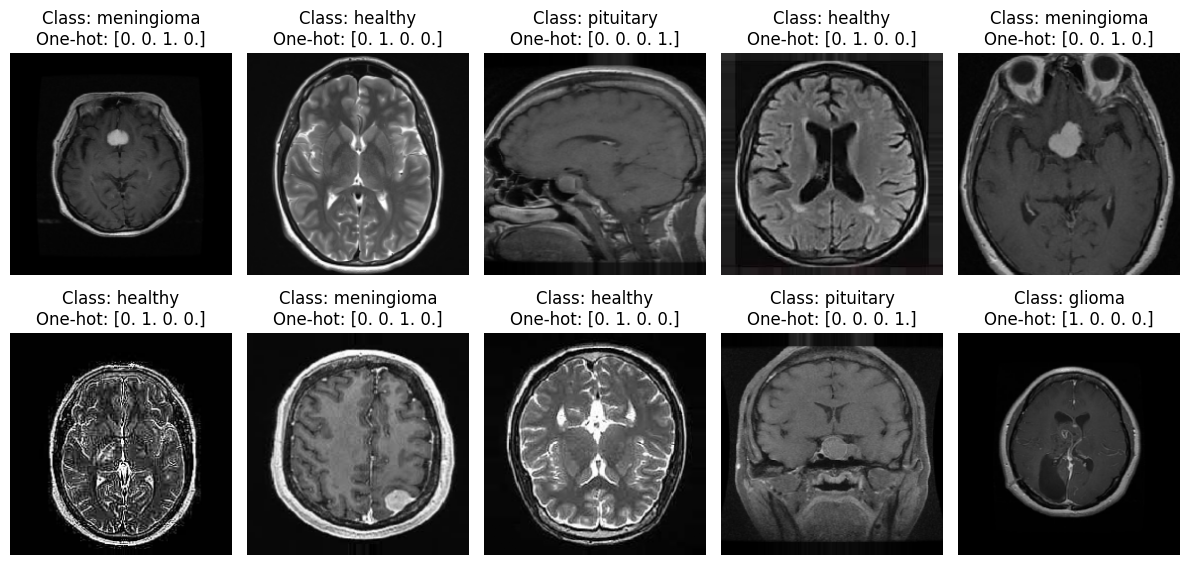

In [9]:
import numpy as np
import matplotlib.pyplot as plt

images, labels = next(train_generator)  # Get one batch of data from training set

# Get the class label mapping (e.g., {0: 'class0', 1: 'class1', ...})
class_mapping = {v: k for k, v in train_generator.class_indices.items()}

# Randomly select a few samples to visualize
num_samples = 10
random_indices = np.random.choice(range(len(images)), num_samples, replace=False)

# Plot
plt.figure(figsize=(12, 6))
for i, idx in enumerate(random_indices):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[idx])
    one_hot_label = labels[idx]  # Get the one-hot encoded label
    class_label = class_mapping[np.argmax(one_hot_label)]  # Decode the class label
    plt.title(f"Class: {class_label}\nOne-hot: {one_hot_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()



**Model**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),  # Input layer

    # Convolutional Block 1
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Convolutional Block 2
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),

    # Flatten
    layers.Flatten(),

    #Dense Layer
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),

    # Output Layer
    layers.Dense(4, activation='softmax')  # 4 classes (meningioma, glioma, pituitary tumor, and healthy)
])

# Display the model summary
model.summary()

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
              )


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 186624)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │      11,944,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,963,652 (45.64 MB)

 Trainable params: 11,963,652 (45.64 MB)

 Non-trainable params: 0 (0.00 B)

**Model Checkpoint, EarlyStopping and Reduce learning**

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from datetime import datetime
# Early stopping
early_stopping = EarlyStopping(
    monitor='val_loss', #meaning if the validation loss doesn't improve in 3 epochs, it will halt the training process
    patience=4, # Number of epochs with no improvement
    restore_best_weights=True
)

# Reduce learning rate on plateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,   # The factor by which to reduce the learning rate
    patience=4,   # Number of epochs with no improvement before reducing LR
    min_lr=1e-5   # Minimum learning rate
)

# Model checkpoint
timestamp = datetime.now().strftime('%Y%m%d-%H%M%S')
checkpoint_path = f'/content/drive/MyDrive/CNN_Model/model{timestamp}.keras'
checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,           # Only save the best model
    mode='max',
    verbose=1
)

**Train**

In [ ]:
history = model.fit(
    train_generator,
    epochs=10,            # Number of epochs to train
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr, checkpoint]
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.3805 - loss: 1.7611 - precision: 0.4565 - recall: 0.1296 
Epoch 1: val_accuracy improved from -inf to 0.62333, saving model to /content/drive/MyDrive/CNN_Model/model20241127-171957.keras
141/141 ━━━━━━━━━━━━━━━━━━━━ 1380s 9s/step - accuracy: 0.3813 - loss: 1.7573 - precision: 0.4579 - recall: 0.1305 - val_accuracy: 0.6233 - val_loss: 0.8415 - val_precision: 0.7431 - val_recall: 0.4791 - learning_rate: 0.0010
Epoch 2/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - accuracy: 0.6721 - loss: 0.7878 - precision: 0.7475 - recall: 0.5520
Epoch 2: val_accuracy improved from 0.62333 to 0.66162, saving model to /content/drive/MyDrive/CNN_Model/model20241127-171957.keras
141/141 ━━━━━━━━━━━━━━━━━━━━ 114s 602ms/step - accuracy: 0.6722 - loss: 0.7877 - precision: 0.7476 - recall: 0.5521 - val_accuracy: 0.6616 - val_loss: 0.7600 - val_precision: 0.7222 - val_recall: 0.5485 - learning_rate: 0.0010
Epoch 3/10
140/141 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/s

**Visualzie the loss**

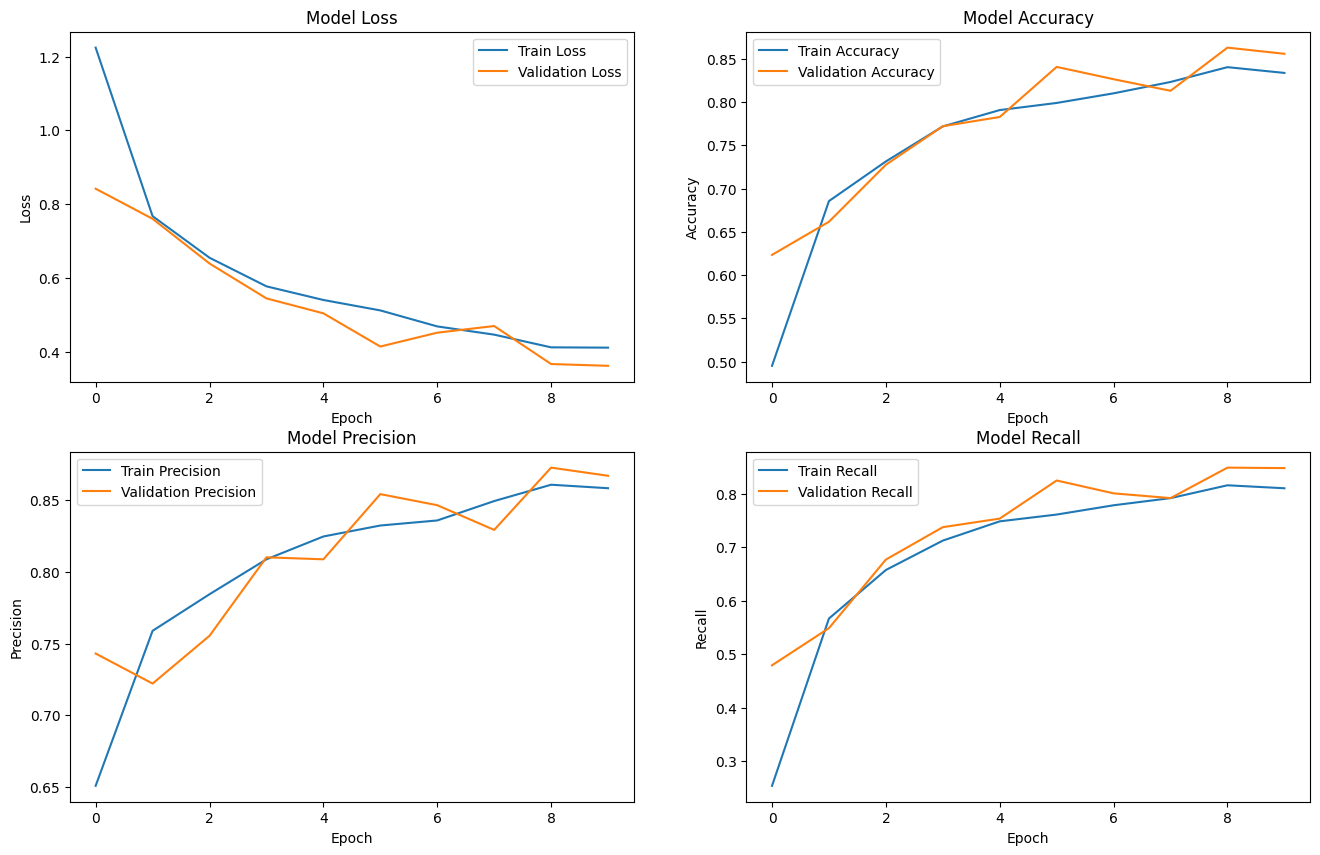

In [ ]:
plt.figure(figsize=(16, 10))

# Plot Loss
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()

# Plot Accuracy
plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()

# Plot Precision
plt.subplot(2, 2, 3)
plt.plot(history.history['precision'], label='Train Precision')
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Model Precision')
plt.legend()

# Plot Recall
plt.subplot(2, 2, 4)
plt.plot(history.history['recall'], label='Train Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Model Recall')
plt.legend()

plt.show()

**Test**

In [ ]:
test_loss, test_accuracy, test_precision_score,test_recall = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy} ")
print(f"Test Precision Score (Macro-averaged): {test_precision_score:}")
print(f"Test Recall Score (Macro-averaged): {test_recall:}")

44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - accuracy: 0.8517 - loss: 0.4120 - precision: 0.8641 - recall: 0.8386
Test Loss: 0.3940815329551697
Test Accuracy: 0.8525640964508057 
Test Precision Score (Macro-averaged): 0.8631039261817932
Test Recall Score (Macro-averaged): 0.8397436141967773


**Visualize**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


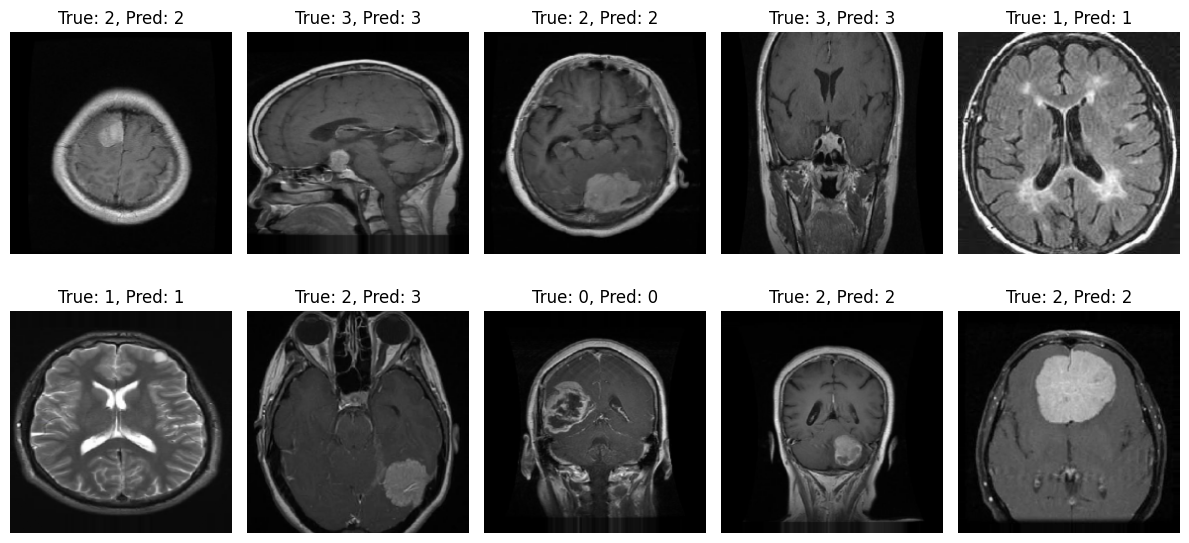

In [ ]:
import random

# Randomly select images from the validation set
sample_images, sample_labels = next(val_generator)
predictions = model.predict(sample_images)

# Visualize the first 10 images
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(sample_images[i])
    true_label = np.argmax(sample_labels[i])
    pred_label = np.argmax(predictions[i])
    plt.title(f"True: {true_label}, Pred: {pred_label}")
    plt.axis('off')
plt.tight_layout()
plt.show()

44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 154ms/step


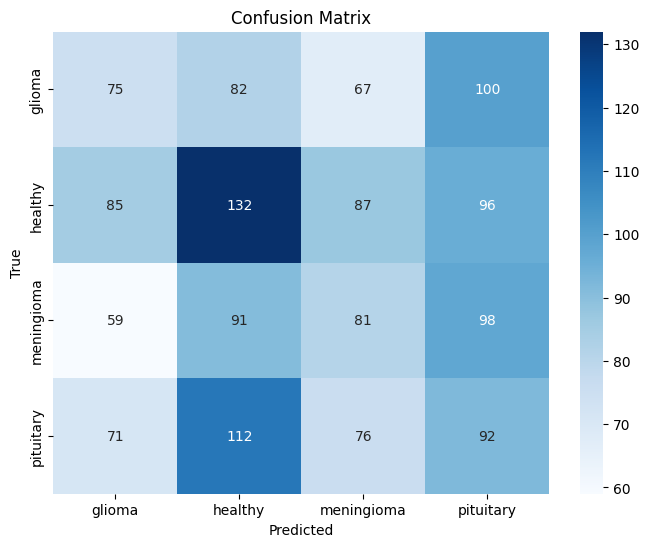

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# Get the true labels and predicted labels from the test generator
y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

# confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()